In [1]:
# Import relevant modules

# Import modules for vector calculations
import numpy as np
import scipy as sp
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt

# Import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
%matplotlib inline

# Import modules for file handling 
import os
import io
import sys
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tifffile import imread, imsave
from skimage import io, measure
import time

# Import modules for Deep Learning
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Import custom modules
from GAP_UNET_ResBlock_Altered import Unet
from BinomDataset import BinomDataset
from Inference import sample_image

In [2]:
!nvidia-smi

Fri Jun  7 17:48:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.83                 Driver Version: 546.83       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P5              16W / 124W |   3403MiB / 12282MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Using the GPU for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
Data = np.concatenate((imread(r'trainingDataGT.tif'), imread(r'testDataGT.tif')))

(2048, 512, 512)


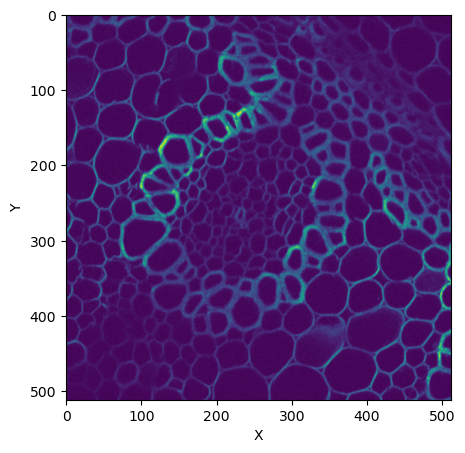

In [5]:
# Review the Dataset
plt.figure(figsize=(5,5))
plt.imshow(Data[0], cmap='viridis')
print(Data.shape)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [6]:
def psnrToString(inp):
    if inp < 0:
        return "m"+str(-inp)
    else:
        return str(inp)
    
# We set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5

name = psnrToString(minpsnr) + "to" + psnrToString(maxpsnr) + "-256x256"
CHECKPOINT_PATH = "./models/" 

In [7]:
maxepochs = 20 # Train for longeer if needed

# Create the pytorch dataset
Dataset = BinomDataset(Data[:round(Data.shape[0]*0.8)], 256, minpsnr, maxpsnr, virtSize= 500*32)
Dataset_val = BinomDataset(Data[round(Data.shape[0]*0.8):], 256, minpsnr, maxpsnr)

# Create the Dataloaders for the training and validation sets
Train_Loader = DataLoader(Dataset, batch_size = 32, shuffle = True, drop_last = True, pin_memory=False)
Validation_Loader = DataLoader(Dataset_val, batch_size = 32, shuffle = False, drop_last = True, pin_memory=False)

img = next(iter(Train_Loader))

print("Image Shape: ",img.shape)

# Define the callbacks for the model training and validation.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)


# Create the U-net model
in_channels = 1
levels = 10
depth = 6
start_filts = 28
up_mode = 'transpose'

Model = Unet(in_channels = in_channels, levels=levels, depth=depth,
                 start_filts=start_filts, up_mode = up_mode).to(device)
summary(Model, (1, 256, 256))

Image Shape:  torch.Size([32, 2, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 28, 256, 256]           2,548
            Conv2d-2         [-1, 28, 256, 256]             308
            Conv2d-3         [-1, 28, 256, 256]           2,548
            Conv2d-4         [-1, 28, 256, 256]           7,028
            Conv2d-5         [-1, 28, 256, 256]           2,380
       BatchNorm2d-6         [-1, 28, 256, 256]              56
   Inception_Block-7         [-1, 28, 256, 256]               0
            Conv2d-8         [-1, 28, 256, 256]           7,084
       BatchNorm2d-9         [-1, 28, 256, 256]              56
        MaxPool2d-10         [-1, 28, 128, 128]               0
DownSampling_Block-11  [[-1, 28, 128, 128], [-1, 28, 256, 256]]               0
           Conv2d-12         [-1, 56, 128, 128]          14,168
           Conv2d-13         [-1, 56, 128, 

In [8]:
# Define the Pytorch Trainer
Trainer = pl.Trainer(accelerator = "gpu", max_epochs=maxepochs, callbacks=[early_stopping_callback, lr_monitor, checkpoint_callback], gradient_clip_val=0.5, devices=[0])
Trainer.fit(Model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH,name) + ".ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | ModuleList | 36.4 M
1 | decoder    | ModuleList | 9.4 M 
2 | final_conv | Conv2d     | 29    
------------------------------------------
45.8 M    Trainable params
0         Non-trainable params
45.8 M    Total params
183.042   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: -0.193
Epoch 0, global step 500: 'val_loss' reached -0.19319 (best -0.19319), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_15\\checkpoints\\epoch=0-step=500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: -0.206
Epoch 1, global step 1000: 'val_loss' reached -0.20600 (best -0.20600), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_15\\checkpoints\\epoch=1-step=1000.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: -0.223
Epoch 4, global step 2500: 'val_loss' reached -0.22259 (best -0.22259), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_15\\checkpoints\\epoch=4-step=2500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 3500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 4000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 4500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 5000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 5500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 6000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -0.229
Epoch 12, global step 6500: 'val_loss' reached -0.22910 (best -0.22910), saving model to "c:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\lightning_logs\\version_15\\checkpoints\\epoch=12-step=6500.ckpt" as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 7000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 7500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 8000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 8500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 9000: 'val_loss' was not in top 1


In [8]:
model = Unet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [9]:
dataTest = imread(r'testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT = imread(r'testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

332 0 44.3373404001294 272.0 17.0


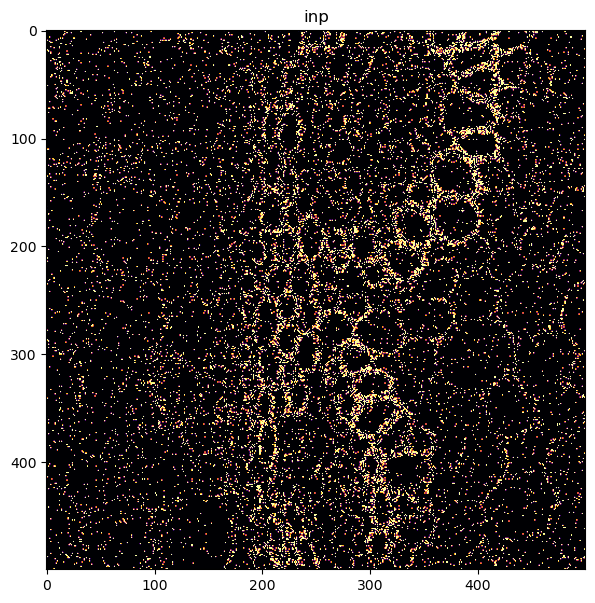

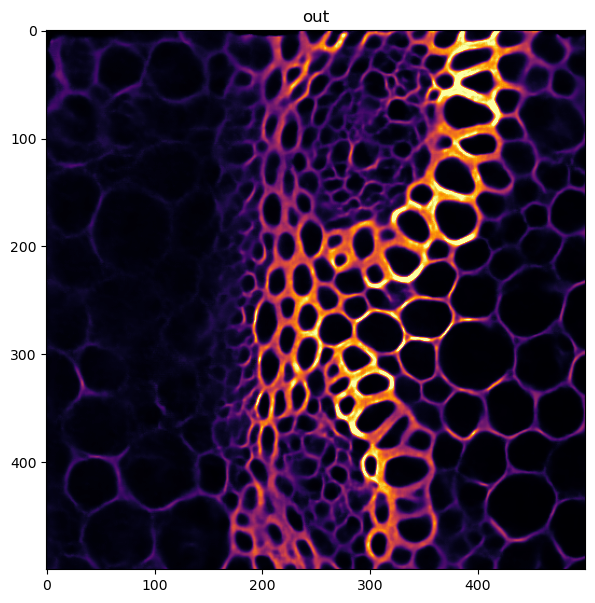

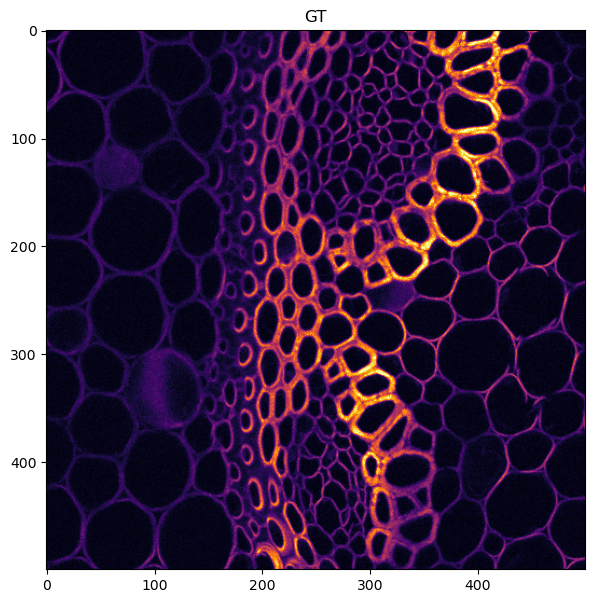

In [10]:
outputs = []
for inp, gt in zip(dataTest, dataTestGT):  
    inpT = torch.from_numpy(inp.astype(np.float32)).to(device)
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None,None,...]).detach().cpu())
    out = inp.sum() * out / out.sum()
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()

In [11]:
outputs = np.array(outputs)
imsave(r'output.tif',outputs, imagej = True)

(1, 1, 256, 256)


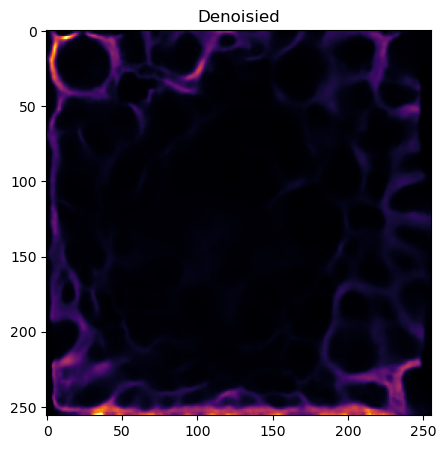

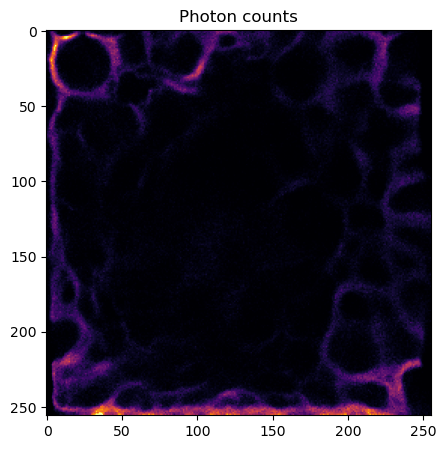

_______________________________________ 2
time (s): 0.47002625465393066 time per image (s) 0.47002625465393066
(1, 1, 256, 256)


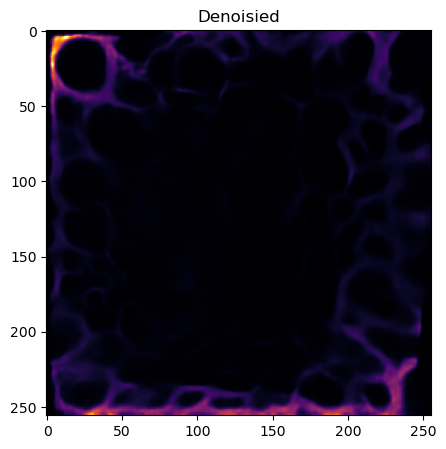

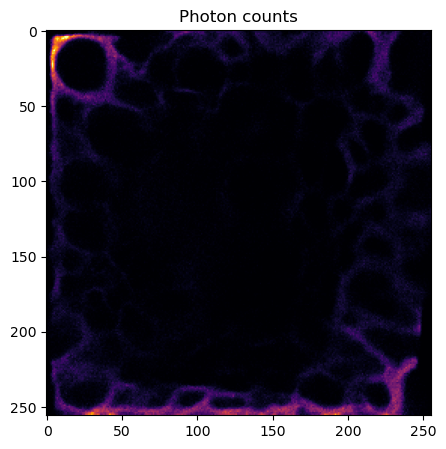

_______________________________________ 2
time (s): 0.2533721923828125 time per image (s) 0.2533721923828125


In [17]:

import matplotlib.image as mpimg
import time
import numpy as np
from Inference import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 256
pixels_y = 256

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)


for i in range(2):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -5)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])

0


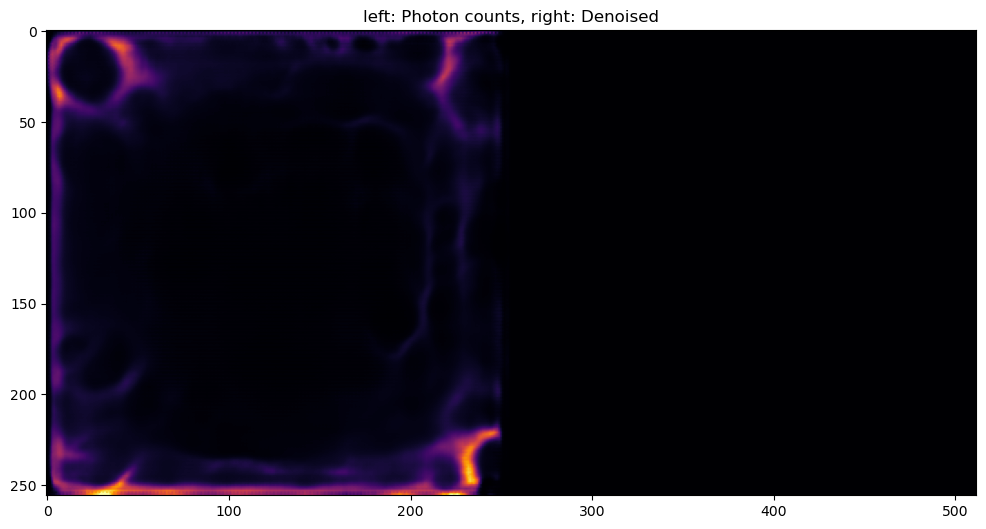

In [19]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()